In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt

In [0]:
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']

def removeData(images, labels):
  '''Remove images and labels that are unknown'''
  arr_img = []
  arr_label = []
  for i in range(images.shape[0]):
    if labels[i][0].lower() in letters:
      arr_img.append(images[i])
      arr_label.append(labels[i][0].lower())
  return np.array(arr_img), np.array(arr_label)

In [0]:
# Load original data
X1 = np.load('train_data.npy')
y1 = np.load('train_labels.npy')

# Load data we collected for lab 1
X2 = np.load('data.npy')
y2 = np.load('labels.npy')

# Load data Raymond and Yadi collected
X3 = np.load('new_data.npy')
y3 = np.load('new_labels.npy')

# Load data Suman collected
X4 = np.load('Suman_data.npy')
y4 = np.load('Suman_labels.npy')

# Load data Natalia collected
X5 = np.load('nat_data.npy')
y5 = np.load('nat_labels.npy')

# Load noisy data Raymond collected
X6 = np.load('noisy_data.npy')
y6 = np.load('noisy_labels.npy')

In [4]:
X_og = np.concatenate((X1, X2, X3, X4, X5, X6), axis=0)
y_og = np.concatenate((y1.reshape(-1, 1), y2.reshape(-1, 1), y3.reshape(-1, 1), 
                    y4.reshape(-1, 1), y5.reshape(-1, 1), y6.reshape(-1, 1)), 
                    axis=0)
X, y = removeData(X_og, y_og)
print(X.shape, y.shape)

# Pre-process and resize images
X = preprocess_input(X)
X_resized = np.array([resize(image, (96, 96)) for image in X])
print(X_resized.shape)

# Use one-hot encoding for labels
onehot_encoder = OneHotEncoder(sparse=False)
one_hot_y = onehot_encoder.fit_transform(y.reshape(-1, 1))

# Train validation split
X_train, X_val, y_train, y_val = train_test_split(X_resized, one_hot_y, test_size=0.2)

(2637, 100, 100, 3) (2637,)
(2637, 96, 96, 3)


In [5]:
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{'a': 305,
 'b': 306,
 'c': 296,
 'd': 287,
 'e': 284,
 'f': 288,
 'g': 290,
 'h': 289,
 'i': 292}

In [0]:
# Training data generator
datagen_train = ImageDataGenerator(
      zoom_range=[0.8,1.0], 
      horizontal_flip=True, 
      vertical_flip=True, 
      rotation_range=90
      )

In [0]:
# Validation data generator
datagen_val = ImageDataGenerator()

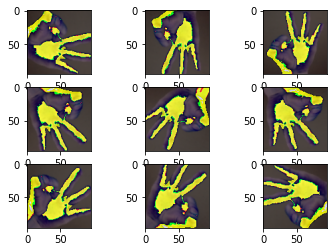

In [8]:
# Visualize augmented images

data = X_train[0]
# expand dimension to one sample
sample = expand_dims(data, 0)
# prepare iterator of image data augmentation generator
it = datagen_train.flow(sample)
# generate samples and plot
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()

In [0]:
batch_size = 150

generator_train = datagen_train.flow(x=X_train, y=y_train,
                                    batch_size=batch_size,
                                    shuffle=True)

In [0]:
generator_val = datagen_val.flow(x=X_val, y=y_val,
                                  batch_size=batch_size,
                                  shuffle=False)

In [11]:
steps_val = generator_val.n / batch_size
steps_val

3.52

In [12]:
IMG_SIZE = 96
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Load VGG-16 model
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
base_model.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


In [13]:
num_classes = one_hot_y.shape[1]
num_classes

9

In [0]:
model = Sequential ([
    base_model,
    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    Flatten(),
    # Add 2 fully-connected layers.
    # This is for combining features that the VGG16 model has
    Dense(4608, activation='relu'),
    Dense(1024, activation='relu'),   
    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data
    Dropout(0.5),
    # Add the final layer for the actual classification.
    Dense(num_classes, activation='softmax')                          
])

In [0]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', 
                               patience=30, restore_best_weights=True, 
                               verbose=1)

In [17]:
epochs = 300
steps_per_epoch = 40

history = model.fit(x=generator_train, epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=generator_val,
                    validation_steps=steps_val,
                    callbacks=[early_stopping])

Epoch 1/300
40/40 [==============================] - 14s 343ms/step - loss: 10.0259 - accuracy: 0.2195 - val_loss: 1.7796 - val_accuracy: 0.3466
Epoch 2/300
40/40 [==============================] - 13s 322ms/step - loss: 1.6802 - accuracy: 0.3893 - val_loss: 1.3358 - val_accuracy: 0.5455
Epoch 3/300
40/40 [==============================] - 13s 322ms/step - loss: 1.3170 - accuracy: 0.5177 - val_loss: 1.0534 - val_accuracy: 0.6420
Epoch 4/300
40/40 [==============================] - 13s 328ms/step - loss: 1.1202 - accuracy: 0.6053 - val_loss: 0.9524 - val_accuracy: 0.6932
Epoch 5/300
40/40 [==============================] - 13s 324ms/step - loss: 0.9686 - accuracy: 0.6579 - val_loss: 0.7922 - val_accuracy: 0.7045
Epoch 6/300
40/40 [==============================] - 13s 320ms/step - loss: 0.8127 - accuracy: 0.7041 - val_loss: 0.7473 - val_accuracy: 0.7311
Epoch 7/300
40/40 [==============================] - 13s 326ms/step - loss: 0.6720 - accuracy: 0.7623 - val_loss: 0.6875 - val_accuracy

In [0]:
def plot_training_history(history):
    acc = history.history['accuracy']
    loss = history.history['loss']

    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, color='b', label='Training Acc.')
    # plt.plot(loss, '--', color='b', label='Training Loss')
    
    # Plot it for the validation set.
    plt.plot(val_acc, color='r', label='Validation Acc.')
    plt.plot(val_loss, '--', color='r', label='Validation Loss')

    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

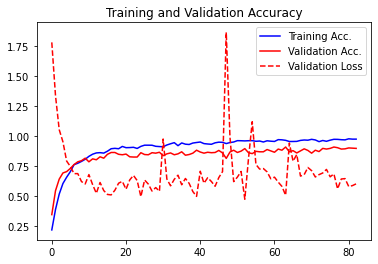

In [19]:
plot_training_history(history)

In [0]:
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred,axis=1)

In [21]:
y_true = np.argmax(y_val,axis=1)

cm = confusion_matrix(y_true, y_pred)
cm

array([[71,  0,  1,  0,  1,  1,  3,  0,  2],
       [ 0, 62,  1,  0,  1,  2,  0,  1,  0],
       [ 2,  2, 52,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0, 55,  0,  0,  1,  0,  2],
       [ 2,  0,  4,  0, 43,  0,  0,  0,  0],
       [ 0,  1,  0,  2,  0, 46,  1,  1,  1],
       [ 0,  0,  0,  1,  0,  0, 56,  3,  3],
       [ 0,  0,  0,  0,  0,  0,  8, 39,  0],
       [ 2,  0,  0,  3,  0,  0,  1,  1, 49]])

In [22]:
score = accuracy_score(y_true, y_pred)
print('Validation Accuracy:', score)

target_names = np.unique(y)
print(classification_report(y_true, y_pred, target_names=target_names))

Validation Accuracy: 0.8958333333333334
              precision    recall  f1-score   support

           a       0.92      0.90      0.91        79
           b       0.94      0.93      0.93        67
           c       0.90      0.93      0.91        56
           d       0.90      0.93      0.92        59
           e       0.96      0.88      0.91        49
           f       0.94      0.88      0.91        52
           g       0.80      0.89      0.84        63
           h       0.87      0.83      0.85        47
           i       0.86      0.88      0.87        56

    accuracy                           0.90       528
   macro avg       0.90      0.89      0.89       528
weighted avg       0.90      0.90      0.90       528



In [0]:
# Unfreeze the pre-trained model for fine-tuning
base_model.trainable = True

In [0]:
for layer in base_model.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block5' in layer.name or 'block4' in layer.name)
    
    # Set the layer's bool.
    layer.trainable = trainable

In [25]:
for layer in base_model.layers:
    print("{0}:\t{1}".format(layer.trainable, layer.name))

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [0]:
model.compile(optimizer=Adam(lr=1e-7), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
epochs = 500
steps_per_epoch = 40

history = model.fit(x=generator_train, epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=generator_val,
                    validation_steps=steps_val,
                    callbacks=[early_stopping])

Epoch 1/500
40/40 [==============================] - 13s 321ms/step - loss: 0.1136 - accuracy: 0.9638 - val_loss: 0.4690 - val_accuracy: 0.8939
Epoch 2/500
40/40 [==============================] - 13s 327ms/step - loss: 0.1084 - accuracy: 0.9675 - val_loss: 0.4649 - val_accuracy: 0.8977
Epoch 3/500
40/40 [==============================] - 13s 320ms/step - loss: 0.1242 - accuracy: 0.9654 - val_loss: 0.4605 - val_accuracy: 0.9015
Epoch 4/500
40/40 [==============================] - 13s 320ms/step - loss: 0.1069 - accuracy: 0.9663 - val_loss: 0.4600 - val_accuracy: 0.8977
Epoch 5/500
40/40 [==============================] - 13s 323ms/step - loss: 0.1226 - accuracy: 0.9675 - val_loss: 0.4586 - val_accuracy: 0.8996
Epoch 6/500
40/40 [==============================] - 13s 317ms/step - loss: 0.1052 - accuracy: 0.9702 - val_loss: 0.4568 - val_accuracy: 0.8996
Epoch 7/500
40/40 [==============================] - 13s 321ms/step - loss: 0.1266 - accuracy: 0.9675 - val_loss: 0.4534 - val_accuracy:

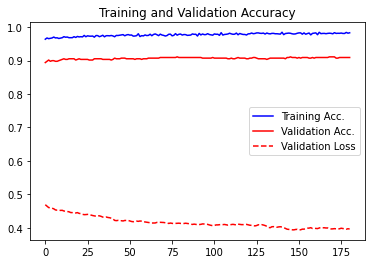

In [28]:
plot_training_history(history)

In [29]:
y_pred = model.predict(X_train)
y_pred = np.argmax(y_pred,axis=1)

y_true = np.argmax(y_train,axis=1)

cm = confusion_matrix(y_true, y_pred)
cm

array([[223,   0,   0,   1,   1,   0,   0,   0,   1],
       [  0, 234,   3,   0,   0,   1,   0,   0,   1],
       [  0,   1, 237,   0,   1,   1,   0,   0,   0],
       [  0,   0,   0, 226,   0,   0,   2,   0,   0],
       [  3,   0,   1,   1, 230,   0,   0,   0,   0],
       [  0,   0,   0,   3,   0, 228,   1,   2,   2],
       [  1,   0,   0,   0,   1,   0, 219,   5,   1],
       [  0,   0,   0,   0,   0,   1,   9, 232,   0],
       [  1,   1,   0,   3,   1,   0,   1,   0, 229]])

In [30]:
score = accuracy_score(y_true, y_pred)
print('Training Accuracy:', score)
print(classification_report(y_true, y_pred, target_names=target_names))

Training Accuracy: 0.9758179231863442
              precision    recall  f1-score   support

           a       0.98      0.99      0.98       226
           b       0.99      0.98      0.99       239
           c       0.98      0.99      0.99       240
           d       0.97      0.99      0.98       228
           e       0.98      0.98      0.98       235
           f       0.99      0.97      0.98       236
           g       0.94      0.96      0.95       227
           h       0.97      0.96      0.96       242
           i       0.98      0.97      0.97       236

    accuracy                           0.98      2109
   macro avg       0.98      0.98      0.98      2109
weighted avg       0.98      0.98      0.98      2109



In [31]:
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred,axis=1)

y_true = np.argmax(y_val,axis=1)

cm = confusion_matrix(y_true, y_pred)
cm

array([[70,  0,  1,  0,  2,  1,  3,  0,  2],
       [ 0, 65,  0,  1,  0,  1,  0,  0,  0],
       [ 1,  2, 52,  0,  1,  0,  0,  0,  0],
       [ 1,  0,  0, 53,  0,  0,  1,  1,  3],
       [ 2,  0,  4,  0, 43,  0,  0,  0,  0],
       [ 0,  0,  1,  2,  0, 49,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0, 56,  3,  3],
       [ 0,  0,  0,  0,  0,  0,  5, 42,  0],
       [ 1,  0,  0,  3,  0,  0,  1,  1, 50]])

In [32]:
score = accuracy_score(y_true, y_pred)
print('Validation Accuracy:', score)
print(classification_report(y_true, y_pred, target_names=target_names))

Validation Accuracy: 0.9090909090909091
              precision    recall  f1-score   support

           a       0.93      0.89      0.91        79
           b       0.97      0.97      0.97        67
           c       0.90      0.93      0.91        56
           d       0.88      0.90      0.89        59
           e       0.93      0.88      0.91        49
           f       0.96      0.94      0.95        52
           g       0.85      0.89      0.87        63
           h       0.89      0.89      0.89        47
           i       0.86      0.89      0.88        56

    accuracy                           0.91       528
   macro avg       0.91      0.91      0.91       528
weighted avg       0.91      0.91      0.91       528



In [0]:
def getLabels(y_pred, threshold):
  y_pred_label = []
  for label in y_pred:
    append = False
    for prob in label:
      if prob >= threshold:
        y_pred_label.append(np.argmax(label))
        append = True
        break
    if not append:
      y_pred_label.append(9) # change this to -1
  return y_pred_label

In [63]:
X_og = preprocess_input(X_og)
X_og = np.array([resize(image, (96, 96)) for image in X_og])

y_pred = model.predict(X_og)
y_pred_label = getLabels(y_pred, 0.55)
  
y_og = np.array([i[0].lower() for i in y_og])
one_hot_y = onehot_encoder.fit_transform(y_og.reshape(-1, 1))
y_true = np.argmax(one_hot_y,axis=1)

cm = confusion_matrix(y_true, y_pred_label)
cm

array([[293,   0,   1,   1,   2,   1,   1,   0,   2,   4],
       [  0, 299,   1,   0,   0,   2,   0,   0,   1,   3],
       [  1,   3, 287,   0,   2,   1,   0,   0,   0,   2],
       [  0,   0,   0, 279,   0,   0,   3,   0,   1,   4],
       [  5,   0,   4,   1, 270,   0,   0,   0,   0,   4],
       [  0,   0,   1,   5,   0, 277,   0,   2,   1,   2],
       [  1,   0,   0,   1,   1,   0, 275,   8,   3,   1],
       [  0,   0,   0,   0,   0,   1,  14, 273,   0,   1],
       [  2,   0,   0,   5,   1,   0,   2,   1, 277,   4],
       [  1,   0,   0,   0,   0,   0,   1,   3,   2,   1]])

In [64]:
score = accuracy_score(y_true, y_pred_label)
print('Overall Accuracy:', score)

target_names = np.unique(y_og)
print(classification_report(y_true, y_pred_label, target_names=target_names))

Overall Accuracy: 0.9568998109640832
              precision    recall  f1-score   support

           a       0.97      0.96      0.96       305
           b       0.99      0.98      0.98       306
           c       0.98      0.97      0.97       296
           d       0.96      0.97      0.96       287
           e       0.98      0.95      0.96       284
           f       0.98      0.96      0.97       288
           g       0.93      0.95      0.94       290
           h       0.95      0.94      0.95       289
           i       0.97      0.95      0.96       292
     unknown       0.04      0.12      0.06         8

    accuracy                           0.96      2645
   macro avg       0.87      0.88      0.87      2645
weighted avg       0.96      0.96      0.96      2645



In [36]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
model.save('/content/drive/My Drive/model2.h5') 